In [1]:
import os
import torch 
import numpy as np
import pandas as pd

/tmp/ipykernel_18505/3864702482.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Check zenodo classifier

In [2]:
clf_prot = torch.load("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/classifier_protein.pth", map_location=torch.device('cpu'))

In [3]:
clf_prot

OrderedDict([('first_layer.weight',
              tensor([[ 0.0435,  0.0267,  0.0190,  ..., -0.0257, -0.0386,  0.0078],
                      [-0.0114,  0.0211,  0.0083,  ...,  0.0093, -0.0300, -0.0087],
                      [ 0.0466,  0.0335,  0.0337,  ...,  0.0204, -0.0174,  0.0105],
                      ...,
                      [ 0.0061,  0.0095, -0.0381,  ..., -0.0134,  0.0101,  0.0318],
                      [-0.0161, -0.0043,  0.0285,  ...,  0.0147, -0.0114, -0.0387],
                      [-0.0546, -0.0094,  0.0481,  ..., -0.0204, -0.0384, -0.0052]])),
             ('first_layer.bias',
              tensor([ 0.0406, -0.0167,  0.0387,  ...,  0.0144,  0.0072,  0.0094])),
             ('final_layer.weight',
              tensor([[-0.0094,  0.0184, -0.0375,  ..., -0.0388, -0.0177,  0.0166],
                      [-0.0350,  0.0026,  0.0257,  ..., -0.0382, -0.0102,  0.0050],
                      [-0.0319, -0.0021,  0.0237,  ...,  0.0119, -0.0194, -0.0106],
                      .

### Run zenodo classifier with zenodo DINO_HPA_FOV_features.pth and compare against zenodo whole_images.csv:

In [4]:
import argparse
from utils.classification_utils import get_classifier
from utils.label_dict import protein_to_num_full

In [5]:
args = argparse.Namespace()

In [6]:
embed_dim = 768
args.competition_type = "whole_images"
args.num_classes = 28
args.classifier_type = "residual_add_clf"
args.n_layers = 2
args.n_units = 1024
args.skip = False
args.classifier_state_dict = "/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/classifier_protein.pth"
args.test_path = "/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_features_for_HPA_FOV.pth"

In [7]:
classifier = get_classifier(args, embed_dim)

In [8]:
msg = classifier.load_state_dict(
    torch.load(
        args.classifier_state_dict,
        map_location="cpu",
    )
)
print(msg)

<All keys matched successfully>


In [9]:
target_labels = sorted(list(protein_to_num_full.keys()))

In [10]:
for p in classifier.parameters():
    p.requires_grad = False
    classifier = classifier.eval()

In [11]:
mapping_dict = protein_to_num_full

In [12]:
# features, IDs, impaths = torch.load(args.test_path) ## Features are not structured as expected! 
dino_fts = torch.load(args.test_path, map_location=torch.device('cpu'))
features, IDs, impaths = dino_fts[0], dino_fts[3], dino_fts[4]["file"]

# What does actually happen here???! Is this necessary?
features = torch.Tensor(features)
target_labels = sorted(list(mapping_dict.keys()))
mapping = np.arange(args.num_classes)
for ind, p in enumerate(list(mapping_dict.keys())):
    mapping[ind] = target_labels.index(p)
predictions = []

# Generate predictions from features
for f in features:
    student_output = classifier(f.unsqueeze(0).to("cpu"))
    predictions.append(student_output.cpu().detach().numpy())
preds = np.concatenate(predictions, axis=0)

In [13]:
mapping_dict.keys()

dict_keys(['nucleoplasm', 'nuclear membrane', 'nucleoli', 'nucleoli fibrillar center', 'nuclear speckles', 'nuclear bodies', 'endoplasmic reticulum', 'golgi apparatus', 'peroxisomes', 'endosomes', 'lysosomes', 'intermediate filaments', 'actin filaments', 'focal adhesion sites', 'microtubules', 'microtubule ends', 'cytokinetic bridge', 'mitotic spindle', 'microtubule organizing center', 'centrosome', 'lipid droplets', 'plasma membrane', 'cell junctions', 'mitochondria', 'aggresome', 'cytosol', 'cytoplasmic bodies', 'rods & rings'])

In [14]:
predictions = (
    torch.sigmoid(torch.Tensor(preds)).round().squeeze(1)[:, mapping]
)
submissions = []
for i in predictions:
    if len(i) == 0:
        submissions.append("")
    else:
        submissions.append(" ".join([str(v) for v in np.where(i)[0]]))

submission = pd.DataFrame(zip(IDs, submissions), columns=["Id", "Predicted"])
submission = submission.sort_values(by="Id")

In [15]:
submission

,Id,Predicted
86811,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,0
86812,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,0 1 7
86813,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0 5
86814,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1 25
86815,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0 18
...,...,...
117878,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
117879,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,0 5
117880,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,
117881,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,21 25


In [16]:
# here I analyze the outputs etc. missing predictions and correspondence to zenodo dino_features vs. whole_images.csv

In [17]:
(predictions.sum(axis=1) == 0).sum(), (submission["Predicted"] == "").sum()

(tensor(18232), 18232)

In [18]:
# load zenodo reference csvs and compute scores:
path = "/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/"

zenodo = pd.read_csv(path + "zenodo/whole_images.csv")
train_ids = torch.load(path + "zenodo/train_IDs.pth")
valid_ids = torch.load(path + "zenodo/valid_IDs.pth")

zenodo_u = pd.read_csv(path + "zenodo/whole_images.csv").drop_duplicates(subset="ID")
train_ids = pd.DataFrame(train_ids, columns=["ID"]).drop_duplicates(subset="ID")
valid_ids = pd.DataFrame(valid_ids, columns=["ID"]).drop_duplicates(subset="ID")

In [19]:
# deduplicated train and valid IDs don't account for 27k images...
zenodo_u.shape[0] - train_ids.shape[0] - valid_ids.shape[0], zenodo_u.shape, train_ids.shape[0], valid_ids.shape[0]

(23373, (113545, 68), 72144, 18028)

In [20]:
# There are 10695 images that have no protein_loc label listed in the one-hot matrix. These all correspond to Website labels.
nolabels = zenodo[(zenodo.iloc[:,5:33].sum(axis=1) == 0)]
nolabels.shape, nolabels["protein_location"].unique()

((10695, 68),
 array(["['vesicles']", '[]', "['nucleoli rim', 'vesicles']",
        "['nucleoli rim']", "['nucleoli rim', 'mitotic chromosome']"],
       dtype=object))

In [21]:
nolabels_u = nolabels.drop_duplicates(subset="ID")
nolabels_u.shape

(9937, 68)

Need to remove the images with NO annotations from our classifier training and validation sets! 

In [22]:
clean_train_ids_set = set(train_ids["ID"]) - set(nolabels_u["ID"])
clean_valid_ids_set = set(valid_ids["ID"]) - set(nolabels_u["ID"])
len(clean_train_ids_set)

65593

In [23]:
train_predictions = submission[submission['Id'].isin(train_ids["ID"])].drop_duplicates(subset="Id")
valid_predictions = submission[submission['Id'].isin(valid_ids["ID"])].drop_duplicates(subset="Id")
assert train_predictions["Id"].isin(valid_predictions["Id"]).any() == False

In [45]:
train_predictions = submission[submission['Id'].isin(clean_train_ids_set)].drop_duplicates(subset="Id")
valid_predictions = submission[submission['Id'].isin(clean_valid_ids_set)].drop_duplicates(subset="Id")

In [25]:
# loading annotations from the DINO_features.pth
zenodo_pth_IDs = dino_fts[3]
zenodo_pth_preds = dino_fts[1]
zenodo_pth_targs = dino_fts[2]

In [26]:
zenodo_pth_preds.shape, zenodo_pth_targs.shape

(torch.Size([117883, 28]), (117883, 35))

In [35]:
sum(train_predictions['Correctly_Predicted'] >0)

63293

In [46]:
from sklearn.metrics import f1_score


# Initialize columns for true and predicted labels
valid_predictions['Correctly_Predicted'] = 0.0

# Iterate through each row in train_predictions
for index, row in train_predictions.iterrows():
    true_labels = zenodo_u.loc[zenodo_u["ID"] == row['Id'], mapping_dict.keys()].astype(int)
    predicted_indices = list(map(int, row['Predicted'].split()))
    
    predicted_labels = [0] * len(mapping_dict)
    for idx in predicted_indices:
        predicted_labels[idx] = 1

    true_labels_flat = true_labels.values.flatten()
    
    if true_labels_flat.sum() > 0:  # Avoid division by zero
        f1 = f1_score(true_labels_flat, predicted_labels, average='macro', zero_division=0)
        valid_predictions.at[index, 'Correctly_Predicted'] = f1

In [44]:
train_predictions[63000:]['Correctly_Predicted'].sum() / len(train_predictions[63000:])

0.8044920193261176

In [ ]:


# Initialize columns for true and predicted labels
train_predictions['Correctly_Predicted_handtooled'] = 0.0

# Iterate through each row in train_predictions
for index, row in train_predictions.iterrows():
    true_labels = zenodo_u.loc[zenodo_u["ID"] == row['Id'], mapping_dict.keys()]
    predicted_indices = list(map(int, row['Predicted'].split()))

    true_positive_count = 0.0
    true_label_count = float(true_labels.sum().sum())

    for label in predicted_labels:
        if true_labels[label].any():
            true_positive_count += 1


    train_predictions.at[index, 'Correctly_Predicted_handtooled'] = true_positive_count / true_label_count

t


/tmp/ipykernel_16739/1569721707.py:1: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if true_labels[label].bool():


## Check zenodo feature csvs

In [ ]:
fov_embs = pd.read_csv("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_FOV_embeddings.csv")

In [ ]:
fov_embs # just includes the UMAPs in extra columns

,Unnamed: 0,file,protein_location,cell_type,ID,nucleoplasm,nuclear membrane,nucleoli,nucleoli fibrillar center,nuclear speckles,...,lipid droplets,plasma membrane,cell junctions,mitochondria,aggresome,cytosol,cytoplasmic bodies,rods & rings,UMAP_1,UMAP_2
0,0,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],A-431,49232_769_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-14.328590,-10.398324
1,1,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],A-431,49232_769_H3_11,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-14.977192,-10.265456
2,2,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-2 OS,49232_761_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,13.438740,15.927193
3,3,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-2 OS,49232_761_H3_2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,13.878462,17.346966
4,4,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-251 MG,49232_757_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-16.806204,9.091037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117878,117878,/scr/mdoron/Dino4Cells/data/whole_images/ffed4...,['plasma membrane'],ASC TERT1,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,13.359716,-6.184863
117879,117879,/scr/mdoron/Dino4Cells/data/whole_images/fff0a...,['nuclear bodies'],BJ,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,11.107221,-1.429197
117880,117880,/scr/mdoron/Dino4Cells/data/whole_images/fff18...,['golgi apparatus'],HeLa,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,31.051903,-26.846312
117881,117881,/scr/mdoron/Dino4Cells/data/whole_images/fffdf...,"['cytosol', 'nucleoli', 'plasma membrane']",A-431,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,False,False,True,False,False,...,False,True,False,False,False,True,False,False,30.350204,-26.031130


## Check label distribution in zenodo DINO_fts vs. Master:

In [ ]:
dino_fts = torch.load("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_features_for_HPA_FOV.pth", map_location=torch.device('cpu'))

In [ ]:
for i in dino_fts: 
    try: print(i.shape)
    except: print(len(i))

torch.Size([117883, 768])
torch.Size([117883, 28])
(117883, 35)
117883
(117883, 68)


In [ ]:
dino_fts[1].sum(axis=0)

tensor([ 1769,   494,  2040,  3237,  1245,   716, 34302,  3509,   141,  1196,
         8073,  1850,   356,   132,    43,  1647,  2544,  9509,   438,  5370,
         2756,  4897,  8651,  3310, 50821,   199, 12859,    65])

In [ ]:
path = "/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/"

master = pd.read_csv(path + "Master_fovHPA_512.csv")
zenodo = pd.read_csv(path + "zenodo/whole_images.csv")

In [ ]:
# confirm difference in shape is explained by duplicates in zenodo csv
master.shape, zenodo.shape, zenodo.duplicated(subset="ID").sum()

((113545, 71), (117883, 68), 4338)

In [ ]:
# is there bias with respect to the labels of the duplicated images? 
dups = zenodo[zenodo.duplicated(subset="ID")]

In [ ]:
dups_unique = dups.drop_duplicates(subset="ID")

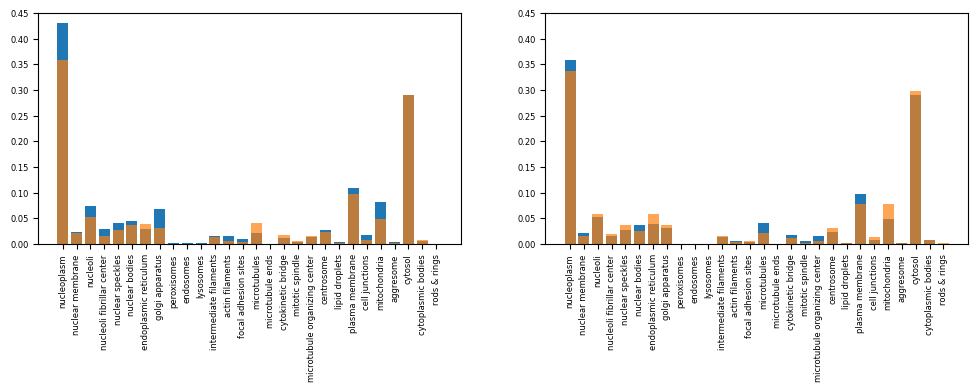

In [ ]:
# check label distribution
import matplotlib.pyplot as plt

prot_col = dups.iloc[:,5:33].columns

# Protein locations:
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].bar(prot_col, zenodo.iloc[:,5:33].sum(axis=0) / zenodo.shape[0])
ax[0].bar(prot_col, dups.iloc[:,5:33].sum(axis=0) / dups.shape[0], alpha=0.7)
ax[1].bar(prot_col, dups.iloc[:,5:33].sum(axis=0) / dups.shape[0])
ax[1].bar(prot_col, dups_unique.iloc[:,5:33].sum(axis=0) / dups_unique.shape[0], alpha=0.7)

for i in range(1): ax[i].tick_params('x', )
for a in ax.flatten():
    a.set_ylim(0,0.45)
    a.tick_params(axis='x', which='major', labelsize=6, labelrotation=90)
    a.tick_params(axis='y', which='major', labelsize=6)

In [ ]:
zenodo_rel = zenodo.iloc[:,5:33].sum(axis=0) / zenodo.shape[0]
dups_rel = dups.iloc[:,5:33].sum(axis=0) / dups.shape[0]

In [ ]:
print("Duplicates in zenodo effectively oversample the following classes:")
for i in prot_col[(dups_rel > zenodo_rel).values]: print(f"-{i}")

Duplicates in zenodo effectively oversample the following classes:
-endoplasmic reticulum
-microtubules
-cytokinetic bridge
-mitotic spindle
-microtubule organizing center
-cytoplasmic bodies


In [ ]:
### check for zenodo df consistency
# Group by 'ID' and check for duplicates with different values
grouped = zenodo.groupby('ID')
differences = {}

for name, group in grouped:
    if len(group) > 1:
        # Check if there are any different values within the group
        if not group.apply(lambda x: x.duplicated(keep=False)).all().all():
            differences[name] = group

# Display the IDs with different values
if differences:
    print("IDs with different values in other columns:")
    for key, value in differences.items():
        print(f"ID: {key}")
        print(value)
else:
    print("No duplicate IDs with different values found.")

IDs with different values in other columns:
ID: 10580_1610_C1_1
       Unnamed: 0                                               file  \
4772         4772  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
4986         4986  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
10962       10962  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
14307       14307  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
19829       19829  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
23702       23702  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
27642       27642  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
41701       41701  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
44965       44965  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
45250       45250  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
52004       52004  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
54341       54341  /scr/mdoron/Dino4Cells/data/whole_images/10580...   
